In [1]:
!pip install --upgrade segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [14]:
!pip install --upgrade torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [15]:
import pickle
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from joblib import load

from pathlib import Path
from sklearn.model_selection import train_test_split
from matplotlib import colors
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torchvision.transforms.functional as F
from tempfile import TemporaryDirectory
import time
import os
from torcheval.metrics.functional import binary_auprc

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PROJECT_PATH ='/content/drive/MyDrive/ESC403_Project/'

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data from Pickle

In [17]:
def load_data(trial: bool, feature_idx: list):
    """ Load Feature Engineered tensor data in .pkl file, applies train-test split. """

    # Read Pickle Data
    data_dir = PROJECT_PATH + 'feature_engineered'
    X = load(data_dir / Path(r"X_fe.pkl"))
    y = load(data_dir / Path(r"y_fe.pkl"))

    # Train test split (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Remove unused features
    retained_features_idx = torch.tensor(feature_idx)
    X_train = torch.index_select(X_train, 3, retained_features_idx)
    X_test = torch.index_select(X_test, 3, retained_features_idx)

    # Set -1 values in fire mask and next-day fire mask to 0
    X_train[:, :, :, 10] = X_train[:, :, :, 10].clamp(min=0, max=1)
    X_test[:, :, :, 10] = X_test[:, :, :, 10].clamp(min=0, max=1)
    y_train[:, :, :, 0] = y_train[:, :, :, 0].clamp(min=0, max=1)
    y_test[:, :, :, 0] = y_test[:, :, :, 0].clamp(min=0, max=1)

    # Permute to adhere to Pytorch Standard (Batch, Channels, Height, Width)
    X_train, X_test, y_train, y_test = [t.permute(0,3,1,2) for t in [X_train, X_test, y_train, y_test]]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data(
    trial=False,
    feature_idx = [0,2,3,4,5,6,7,8,9,10,11,12,14]
)

## Create Dataset Class
Let's define the Dataset Class for training and testing. The validation set gets generated later from the training sets. We define custom datasets inheriting from torch.utils.data.Dataset to create DataLoaders later.

In [124]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __getitem__(self, index):
    # Return input and target value for the given index
    X, y = self.X[index,:,:,:], self.y[index,:,:,:]

    if self.transform:
        # Concatenate X and y to apply same random transforms and then split them again
        X_y = torch.cat((X, y), dim=0)
        X_y = self.transform(X_y)

        X = X_y[:13, :, :]
        y = X_y[13:14, :, :]

    return X, y

  def __len__(self):
    # Return the length of this dataset
    return len(self.X)

## Define Transformations

In [125]:
# Define Transformations. We use a random horizontal and vertical flip followed by a random 32x32
# crop do mitigate our model from predicting fires just in the image center.

# Create sequence of means and standard deviations for each of the 13 channels
mean_stats = X_train.mean(dim=(0, 2, 3), keepdim=True).squeeze().tolist()
std_stats = X_train.std(dim=(0, 2, 3), keepdim=True).squeeze().tolist()

# Fire mask should stay binary
mean_stats[10], std_stats[10] = 0, 1
mean_stats.append(0)
std_stats.append(1)

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(32),
        transforms.Normalize(mean=mean_stats,
                             std=std_stats)
        ])

## Create Datasets and DataLoaders

In [126]:
train_dataset = CustomDataset(
    X_train,
    y_train,
    transform=transform)

test_dataset = CustomDataset(
    X_test,
    y_test,
    transform=transform)

In [127]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Load Model

In [135]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=13,
    classes=1,
    activation = 'sigmoid'
)

## Train Model

In [179]:
def train_model(train_loader, model, num_epochs: int, criterion, optimizer):

    model.to(device)
    since = time.time()

    # Split train_loader into training and validation sets
    data_size = {'train': int(0.8 * len(train_loader.dataset)),
                 'val': len(train_loader.dataset) - int(0.8 * len(train_loader.dataset))}

    train_dataset, val_dataset = random_split(train_loader.dataset, [data_size['train'], data_size['val']])

    dataloaders = {'train': DataLoader(train_dataset, batch_size=train_loader.batch_size, shuffle=True),
                   'val': DataLoader(val_dataset, batch_size=train_loader.batch_size, shuffle=False)}


    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training and Validation phase
            for phase in ['train', 'val']:
                model.train() if phase == 'train' else model.eval()
                running_loss, running_auprc = 0.0, 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device).squeeze()
                    optimizer.zero_grad()

                    # Forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels)

                        # Backward and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)

                    # For Accuracy use AUPRC as we have unbalanced data
                    outputs = (outputs >= 0.5).float()
                    outputs_flat = outputs.view(outputs.shape[0], -1)
                    labels_flat = labels.view(labels.shape[0], -1)

                    auprc = binary_auprc(outputs_flat, labels_flat, num_tasks=len(labels))
                    running_auprc += torch.sum(auprc)

                epoch_loss = running_loss / data_size[phase]
                epoch_auprc = running_auprc.double() / data_size[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} AUPRC: {epoch_auprc:.4f}')

                # Deep copy the model
                if phase == 'val' and epoch_auprc > best_acc:
                    best_acc = epoch_auprc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # Train the best model again on all training data without validation
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return model

In [210]:
num_epochs = 20
eta = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
# Define the weight for positive samples
positive_weight = 2.0  # You can adjust this weight as needed

# Define the loss function with weighted positive samples
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(positive_weight))



model_trained = train_model(train_loader=train_dataloader,
                            model=model,
                            num_epochs=num_epochs,
                            criterion=criterion,
                            optimizer=optimizer
                            )

Epoch 0/19
----------
train Loss: 0.7099 AUPRC: 0.0753
val Loss: 0.7098 AUPRC: 0.0772

Epoch 1/19
----------
train Loss: 0.7099 AUPRC: 0.0714
val Loss: 0.7096 AUPRC: 0.0732

Epoch 2/19
----------
train Loss: 0.7098 AUPRC: 0.0742
val Loss: 0.7102 AUPRC: 0.0659

Epoch 3/19
----------
train Loss: 0.7099 AUPRC: 0.0724
val Loss: 0.7099 AUPRC: 0.0659

Epoch 4/19
----------
train Loss: 0.7098 AUPRC: 0.0755
val Loss: 0.7097 AUPRC: 0.0749

Epoch 5/19
----------
train Loss: 0.7098 AUPRC: 0.0740
val Loss: 0.7094 AUPRC: 0.0774

Epoch 6/19
----------
train Loss: 0.7098 AUPRC: 0.0726
val Loss: 0.7092 AUPRC: 0.0759

Epoch 7/19
----------
train Loss: 0.7099 AUPRC: 0.0728
val Loss: 0.7097 AUPRC: 0.0757

Epoch 8/19
----------
train Loss: 0.7099 AUPRC: 0.0738
val Loss: 0.7097 AUPRC: 0.0755

Epoch 9/19
----------
train Loss: 0.7099 AUPRC: 0.0746
val Loss: 0.7101 AUPRC: 0.0659

Epoch 10/19
----------
train Loss: 0.7097 AUPRC: 0.0743
val Loss: 0.7097 AUPRC: 0.0767

Epoch 11/19
----------
train Loss: 0.7101 

In [211]:
def test_model(model, loader):

    model.eval()
    predictions = []
    true = []

    # Iterate over the test data
    with torch.no_grad(): # We don't need to compute gradients for testing
        for x_batch, t in loader:
            x_batch = x_batch.to(device)
            predicted = model(x_batch)
            predicted = predicted.cpu().numpy()
            predicted[predicted > 0.5] = 1
            predicted[predicted <= 0.5] = 0
            predictions.append(predicted)
            true.append(t.cpu().numpy())

    return predictions, true

In [214]:
pred, true = test_model(model_trained, test_dataloader)
pred = pred[0]
true = true[0]

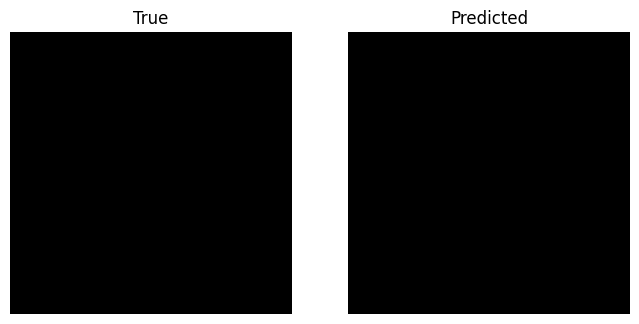

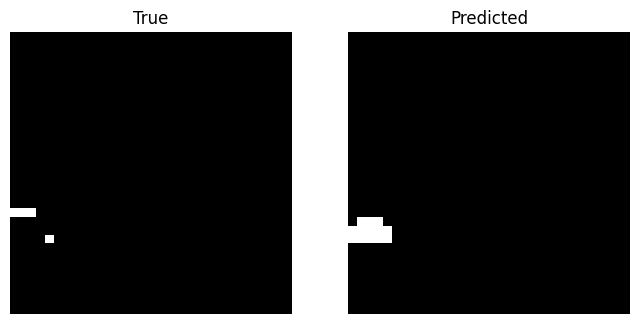

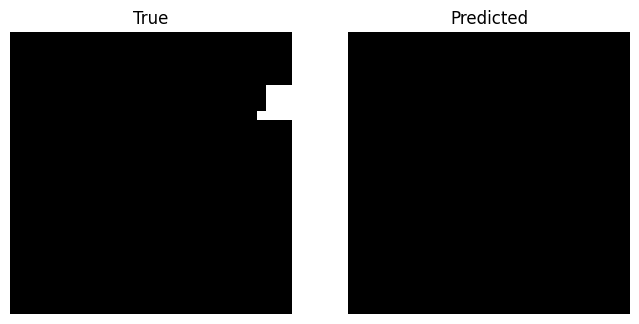

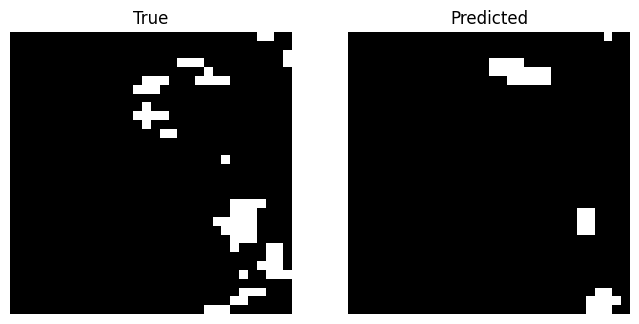

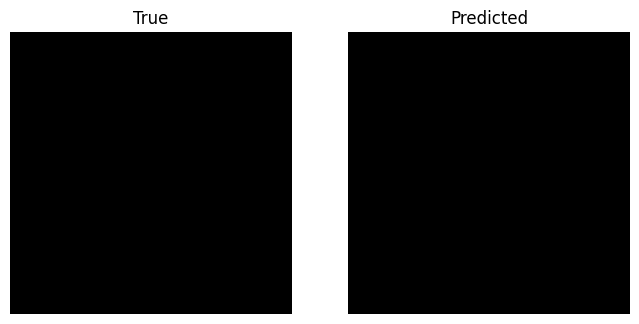

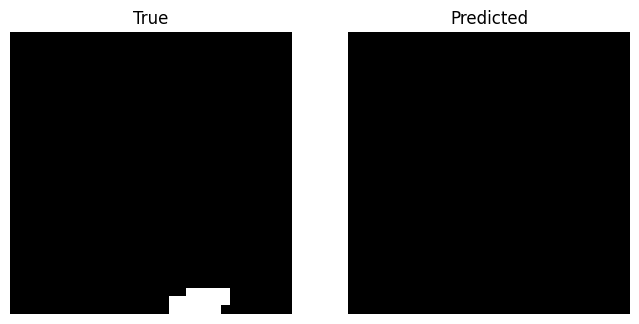

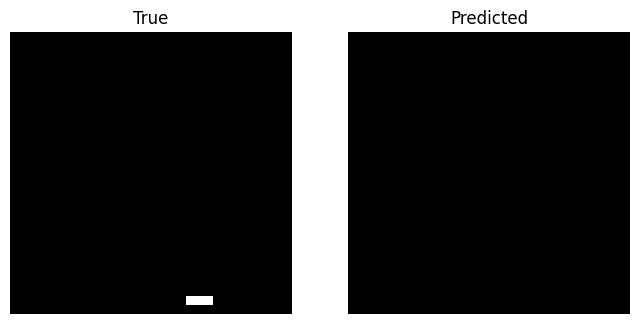

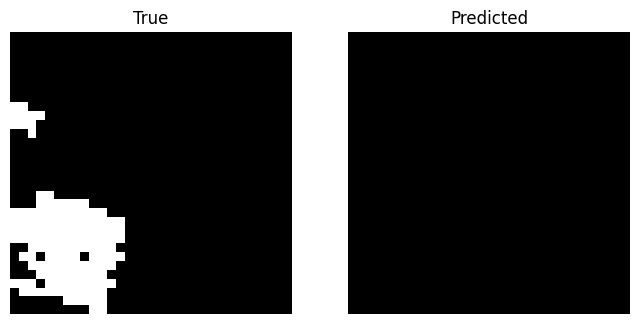

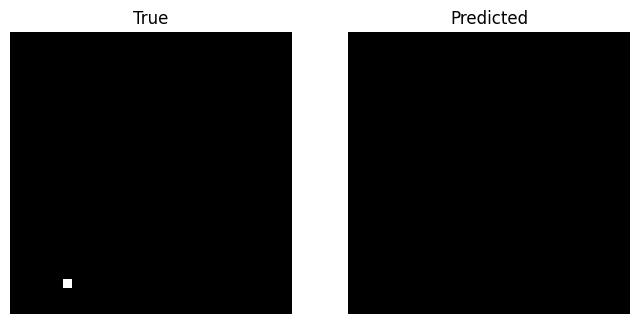

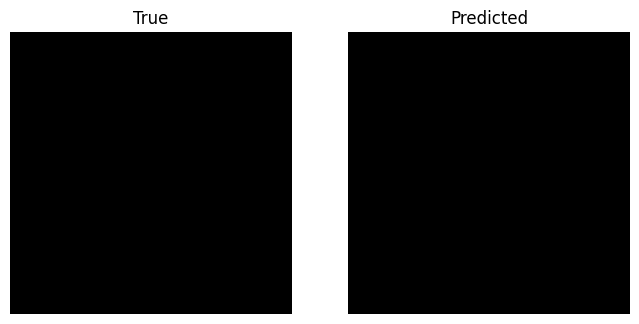

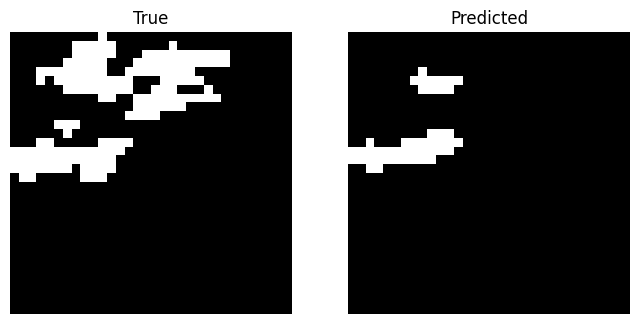

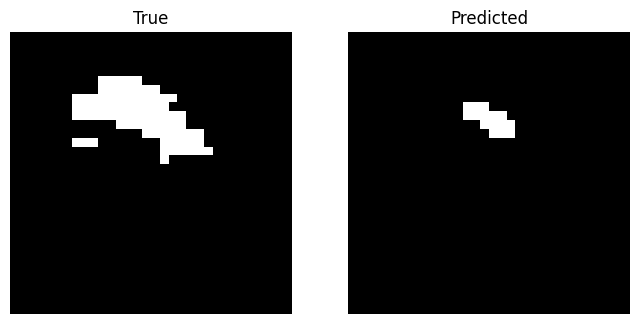

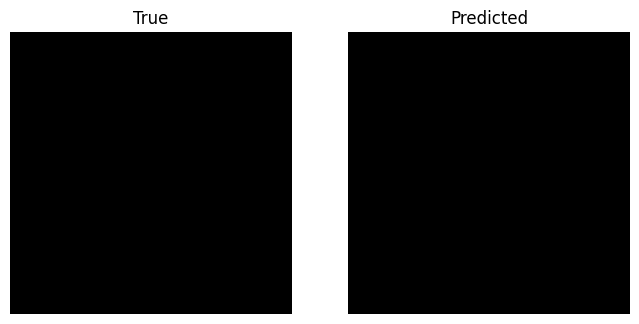

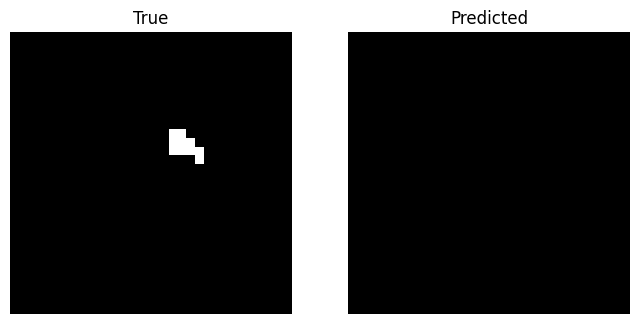

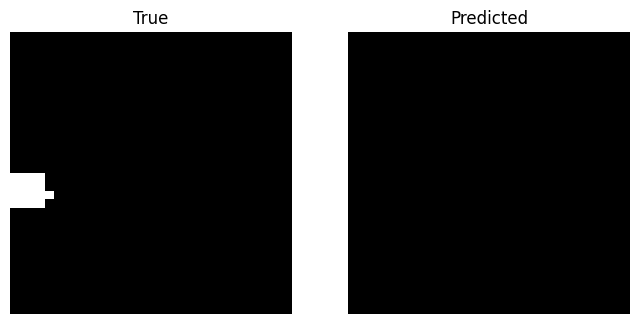

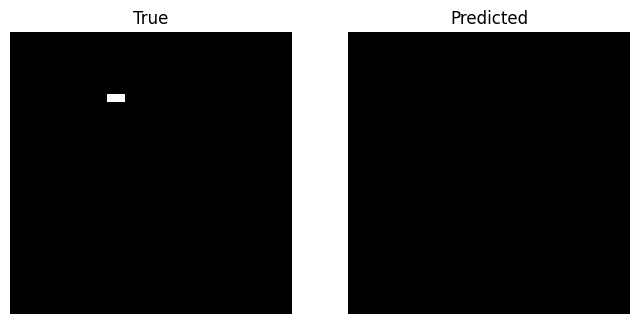

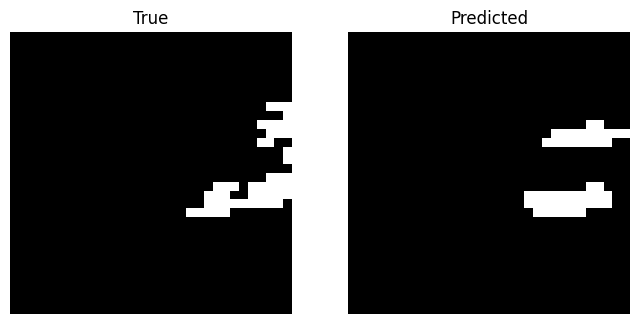

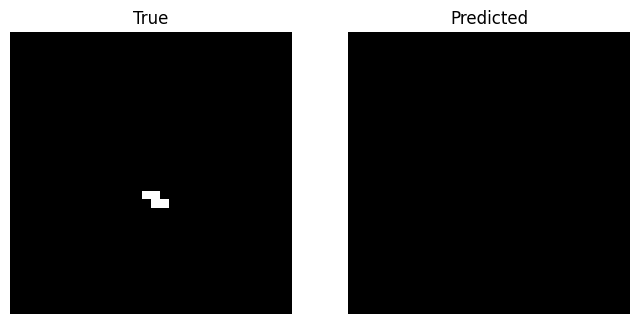

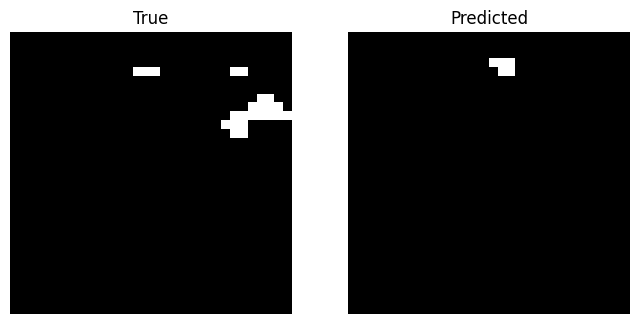

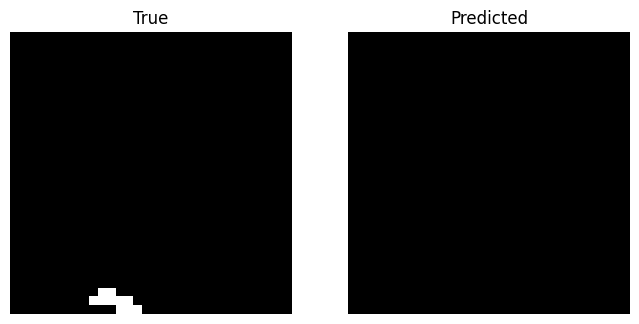

In [219]:
for i in range(20):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the true image
    axs[0].imshow(true[i, 0], cmap='gray')
    axs[0].set_title('True')
    axs[0].axis('off')

    # Plot the predicted image
    axs[1].imshow(pred[i, 0], cmap='gray')
    axs[1].set_title('Predicted')
    axs[1].axis('off')

    plt.show()


In [ ]:
def compute_recall_precision(pred, true):
    # Flatten the arrays for easier comparison
    pred_flat = torch.FloatTensor(pred).flatten()
    true_flat = torch.FloatTensor(true).flatten()

    # Compute True Positives, False Positives, and False Negatives
    TP = np.sum(np.logical_and(pred_flat == 1, true_flat == 1))
    FP = np.sum(np.logical_and(pred_flat == 1, true_flat == 0))
    FN = np.sum(np.logical_and(pred_flat == 0, true_flat == 1))
    TN = np.sum(np.logical_and(pred_flat == 0, true_flat == 0))

    # Compute Accuracy, Recall, and Precision
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    return recall, precision


recall, precision = compute_recall_precision(pred, true)

print("Recall:", recall)
print("Precision:", precision)